In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, MetaData, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
import pandas as pd
import os
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
# Import Matplot lib
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [2]:
# Store filepath in a variable
file_one = os.path.join("Resources", "cleaned_hawaii_measurements.csv")
file_two = os.path.join("Resources", "hawaii_stations.csv")
# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hawaii_measurements_df = pd.read_csv(file_one, encoding="ISO-8859-1")
hawaii_stations_df = pd.read_csv(file_two, encoding="ISO-8859-1")

In [3]:
hawaii_stations_df.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [4]:
# Use Orient='records' to create a list of data to write
# to_dict() cleans out DataFrame metadata as well
# http://pandas-docs.github.io/pandas-docs-travis/io.html#orient-options
station_data = hawaii_stations_df.to_dict(orient='records')
measurement_data = hawaii_measurements_df.to_dict(orient='records')

In [5]:
# Create an engine to a SQLite database file called `customers.sqlite`
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# Create a connection to the engine called `conn`
conn = engine.connect()

In [7]:
# Use MetaData from SQLAlchemy to reflect the tables
metadata = MetaData(bind=engine)
metadata.reflect()

In [8]:
# Save the reference to the `customers` table as a variable called `table`
station_table = sqlalchemy.Table('Station', metadata, autoload=True)
measurement_table = sqlalchemy.Table('Measurement', metadata, autoload=True)

In [9]:
# Use `table.delete()` to remove any pre-existing data.
# Note that this is a convenience function so that you can re-run the example code multiple times.
# You would not likely do this step in production.
conn.execute(station_table.delete())
conn.execute(measurement_table.delete())

In [10]:
# Use `table.insert()` to insert the data into the table
# The SQL table is populated during this step
conn.execute(station_table.insert(), station_data)
conn.execute(measurement_table.insert(), measurement_data)

In [11]:
# Test that the insert works by fetching . 
conn.execute("select * from Station limit 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [12]:
# Test that the insert works by fetching the first 5 rows. 
conn.execute("select * from Measurement limit 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [13]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Start a session to query the database
session = Session(engine)

In [15]:
# Design a query to retrieve the last 12 months of precipitation data.
year_ago = dt.date.today() - dt.timedelta(days = 365)

measurement_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

In [16]:
station_results = session.query(Station.name, Station.station).all()
station_results[0]

('WAIKIKI 717.2, HI US', 'USC00519397')

In [17]:
query_date = dt.date.today() - dt.timedelta(days=365)
print(query_date)

2017-05-13


In [18]:
len(measurement_results)

529

In [19]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [20]:
session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date).first()

('2017-05-13', 0.0)

In [21]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
measurement_results_df = pd.DataFrame(measurement_results, columns=['date', 'prcp'])

measurement_results_df.head()


,date,prcp
0,2017-05-13,0.00
1,2017-05-14,0.00
2,2017-05-15,0.05
3,2017-05-16,0.01
4,2017-05-17,0.00


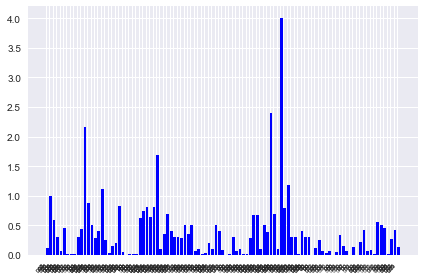

In [22]:
# Plot the results using the DataFrame `plot` method.Plot the results using the DataFrame `plot` method.
plt.bar(measurement_results_df["date"], measurement_results_df["prcp"], color="b", align="edge")
plt.xticks(measurement_results_df["date"], measurement_results_df["prcp"], rotation=50, horizontalalignment='right', size=5)
plt.tight_layout()

In [23]:
# Import Dependencies foor statistics
from statistics import mean, median, mode

In [24]:
#Print mean of Prcp data for last 12 mounts
print("Mean of Prcp Values for last 12 mounts : {}".format(mean(measurement_results_df["prcp"])))

Mean of Prcp Values for last 12 mounts : 0.12079395085066162


In [25]:
#Use Pandas to print the summary statistics for the precipitation data. 
measurement_results_df["prcp"].describe()

count    529.000000
mean       0.120794
std        0.290527
min        0.000000
25%        0.000000
50%        0.020000
75%        0.120000
max        4.000000
Name: prcp, dtype: float64

In [26]:
# Design a query to calculate the total number of stations.
session.query(func.count(Station.name)).all()

[(9)]

In [27]:
# List the stations and observation counts in descending order
session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [28]:
#  Which station has the highest number of observations?
session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).first()

('USC00519281')

In [29]:
last_12_mount_tobs_df = pd.DataFrame(measurement_results, columns=['date', 'tobs'])

In [30]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs)
last_12_mount_tobs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').all()
last_12_mount_tobs_df = pd.DataFrame(last_12_mount_tobs, columns=['station', 'tobs'])
last_12_mount_tobs_df.head()

,station,tobs
0,USC00519281,70
1,USC00519281,62
2,USC00519281,74
3,USC00519281,75
4,USC00519281,74


C:\Users\sinancengiz\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


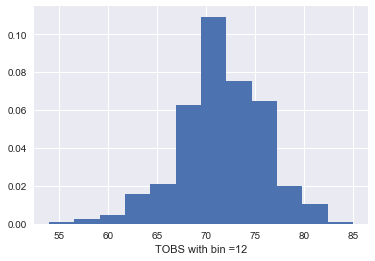

In [31]:
# Plot the results as a histogram with `bins=12`.
plt.hist(last_12_mount_tobs_df["tobs"], normed=True, bins=12)
plt.xlabel('TOBS with bin =12');

In [32]:
# Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` 
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps (start_date, end_date):
    vacation_period_min_temp = session.query(Measurement.tobs).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).order_by(Measurement.tobs).first()
    
    vacation_period_max_temp = session.query(Measurement.tobs).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).order_by(Measurement.tobs.desc()).first()
    
    vacation_period_temps = session.query(Measurement.tobs).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
    total_temp = 0
    temp_count = len(vacation_period_temps)
    min_temp = 0
    max_temp = 0
    for temp in vacation_period_min_temp:
        min_temp += temp
    
    for temp in vacation_period_max_temp:
        max_temp += temp
        
    for temp_tuple in vacation_period_temps:
         for temp in temp_tuple:
                total_temp += temp
    
    avarage_temp_in_vacation_period = total_temp / temp_count
    
    min_max_and_avarage_temp.append(min_temp)    
    min_max_and_avarage_temp.append(avarage_temp_in_vacation_period)
    min_max_and_avarage_temp.append(max_temp)
    print(avarage_temp_in_vacation_period)
    print(min_temp)
    print(max_temp)
    
    

In [33]:
min_max_and_avarage_temp = []
calc_temps("2016-03-07","2016-09-07")

75.05587668593449
62
84


Text(0,0.5,'Temperature Values in Fahrenheit')

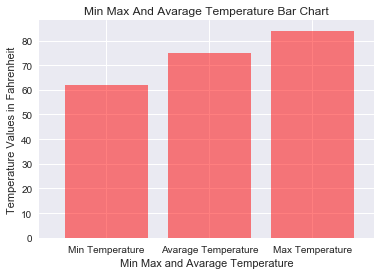

In [34]:
# Create an array that contains the number of users each language has
x_axis = np.arange(len(min_max_and_avarage_temp))
plt.bar(x_axis, min_max_and_avarage_temp, color='r', alpha=0.5, align="edge")
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, ["Min Temperature", "Avarage Temperature", "Max Temperature"])
plt.xlim(-0.25, len(x_axis))
plt.title("Min Max And Avarage Temperature Bar Chart")
plt.xlabel("Min Max and Avarage Temperature")
plt.ylabel("Temperature Values in Fahrenheit")

In [35]:
station_data[0]

{'elevation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [36]:
measurement_data[0]

{'Unnamed: 0': 0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [37]:
from flask import Flask, jsonify

In [38]:
# Flask Setup
app = Flask(__name__)

In [39]:
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start><br/>"
    )

In [40]:
@app.route("/api/v1.0/stations")
def precipitation():
    """Return a list of passenger data including the name, age, and sex of each passenger"""
    # Query all passengers
    results_dic = session.query(Station).all()
    
    # Create a dictionary from the row data and append to a list of all_passengers
    count_station = 0
    all_stations = []
    for station in station_results:
        station_dict = {}
        station_dict["name"] = station_results[count_station][0]
        station_dict["station"] = station_results[count_station][1]
        all_stations.append(station_dict)
        count_station +=1
    
    return jsonify(all_stations)

In [41]:
@app.route("/api/v1.0/precipitation")
def measurement():
    """Return a list of passenger data including the name, age, and sex of each passenger"""
    # Query all passengers
    results_measurement_dic = session.query(Measurement.date,Measurement.tobs,).filter(Measurement.date >= year_ago).all()
    
    # Create a dictionary from the row data and append to a list of all_passengers
    count_measurement = 0
    all_measurements = []
    for station in results_measurement_dic:
        measurement_dict = {}
        measurement_dict["date"] = results_measurement_dic[count_measurement][0]
        measurement_dict["tobs"] = results_measurement_dic[count_measurement][1]
        all_measurements.append(measurement_dict)
        count_measurement +=1
    
    return jsonify(all_measurements)

In [42]:
@app.route("/api/v1.0/tobs")
def tobs():
    
    # Query all passengers
    results_tobs_dic = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).all()
    
    # Create a dictionary from the row data and append to a list of all_passengers
    count_tobs = 0
    all_tobs = []
    for station in results_tobs_dic:
        tobs_dict = {}
        tobs_dict["Temperature"] = results_tobs_dic[count_tobs][0]
        all_tobs.append(tobs_dict)
        count_tobs +=1
    
    return jsonify(all_tobs)

In [ ]:
if __name__ == '__main__':
    app.run(debug=False)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [13/May/2018 19:11:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2018 19:11:34] "GET /api/v1.0/tobs HTTP/1.1" 200 -
